In [43]:
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import time

from utils import JacobiGL, constructV, constructVx, constructD, z2x, z2x_dx, x2z, x2z_dz, JacobiP

sns.set_theme(style="whitegrid")

# Time-dependent problems
## c)

In [44]:
c = 1
x0 = 0
alpha = 15

def f(x, c=c, x0=x0):
    return 1/2 * c / np.cosh(1/2 * np.sqrt(c) * (x - x0))**2

def u_exact(x, t):
    return f(x - c*t)

def u_exact_z(z, t):
    x = alpha/np.pi * z - alpha
    return f(x - c*t)

In [45]:
def diff_mat(N):
    D = np.zeros((N, N))

    # The derivative function
    hj = lambda i, j : 1/2 * (-1)**(i - j) * np.cos(1/N * np.pi * (i - j)) \
                        / np.sin(1/N * np.pi * (i - j))

    # Insert in matrix
    for j in range(N):
        for i in range(N):
            if i != j:
                D[i, j] = hj(i, j)

    return D    





def MOL_KdV(N, t0 = 0, T = 10):
    z = np.linspace(0, 2*np.pi, N)
    u0 = u_exact_z(z, t0)
    
    D = diff_mat(N)

    def rhs(t, u):
        # return -6*np.pi / alpha * max(u0) * D @ u - np.pi**3 / alpha**3 * D @ D @ D @ u 

        return -6*np.pi / alpha * np.diag(u) @ D @ u - np.pi**3 / alpha**3 * D @ D @ D @ u 

    # C = 
    # step = 1/(C*N)
    # t_eval = np.linspace(t0, T, step)

    solver_KdV = scipy.integrate.solve_ivp(
        rhs,
        [t0, T],
        u0, 
        method = 'BDF'
    ) 

    return z, solver_KdV.t, solver_KdV.y.T

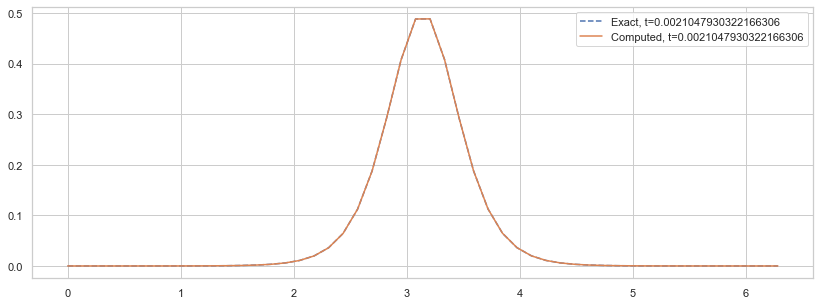

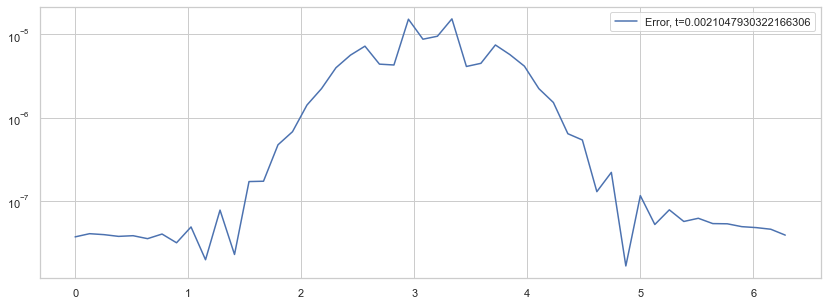

In [46]:
# Short test
N = 50
t0 = 0
T = 3

z, t, u_computed = MOL_KdV(N, t0, T)

fig, ax = plt.subplots(1, 1, figsize=(14,5))

fig2, ax2 = plt.subplots(1, 1, figsize=(14,5))


for i in range(1, len(t), 100):

    uex = u_exact_z(z, t[i])

    ax.plot(z, uex, '--', label=f"Exact, t={t[i]}")
    ax.plot(z, u_computed[i], label=f"Computed, t={t[i]}")

    ax2.plot(z, abs(uex - u_computed[i]), label=f"Error, t={t[i]}")

ax.legend()

ax2.set_yscale('log')
ax2.legend()
plt.show()



## d)

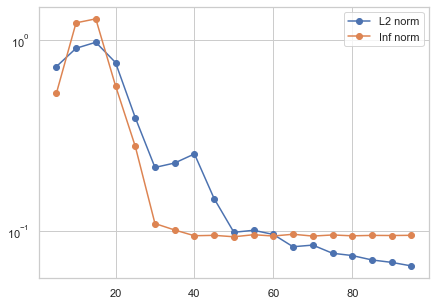

In [47]:
cs = [0.25, 0.5, 1]

Ns = np.arange(5, 100, 5)

errors_L2 = np.zeros_like(Ns, dtype = float)
errors_Linf = np.zeros_like(Ns, dtype = float)

for (i, N) in enumerate(Ns):
    z, t, u_computed = MOL_KdV(N, t0, T)

    X_full_ivp, T_full_ivp = np.meshgrid(z, t)
    U_full = u_exact_z(X_full_ivp, T_full_ivp)
    E = U_full - u_computed

    errors_Linf[i] = np.linalg.norm(E, ord = np.inf)
    errors_L2[i] = np.linalg.norm(E, ord = 'fro')
    

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.plot(Ns, errors_L2, 'o-', label="L2 norm")
ax.plot(Ns, errors_Linf, 'o-', label="Inf norm")
ax.set_yscale('log')
ax.legend()

plt.show()

## h)

In [83]:
def IVP_as_BVP(Nx, Nt, T, a, phi0, gl, gr):
    alpha, beta = 0, 0

    s = JacobiGL(alpha, beta, Nt-1)
    z = JacobiGL(alpha, beta, Nx-1)

    Ds = constructD(s, alpha, beta)
    Dz = constructD(z, alpha, beta)

    Is = np.eye(Nx)
    Iz = np.eye(Nt)

    DDs = np.kron(Ds, Is)
    DDz = np.kron(Iz, Dz)

    L = 2/T * DDs + a/np.pi * DDz

    M = Nt*Nx

    f = np.zeros(M, dtype=float)

    # Boundary conditions
    N = 2*Nt + Nx
    L[M - N:,:] = np.zeros((N, M))
 
    for i in range(M-N, M-2*Nt):
        L[i, ::Nt] = np.ones(Nt)

    f[0:Nt] = gl(s)
    f[Nt*(Nx-1):] = gr(s)
    
    # Initial condition
    f[0::Nt] = phi0(z)

    plt.spy(L)
    plt.grid()


    phi_coeffs = np.linalg.solve(L, f).reshape((Nx, Nt))

    # # Construct Vandermonde matrices
    # Vz = constructV(z, alpha, beta)
    # Vs = constructV(s, alpha, beta)

    # # Calculate Lagrange polynomials
    # grid_unif = np.linspace(-1, 1, M)
    # Phi_unif_s = np.zeros((Nt, M), dtype = float)
    # Phi_unif_z = np.zeros((Nx, M), dtype = float)

    # for n in range(Nt):
    #     Phi_unif_s[n] = JacobiP(grid_unif, 0, 0, n)
    
    # for n in range(Nx):
    #     Phi_unif_z[n] = JacobiP(grid_unif, 0, 0, n)
    
    # # Calculate Lagrange polynomials as before
    # hs = np.zeros((Nt, M), dtype=float)
    # hz = np.zeros((Nx, M), dtype=float)

    # for i in range(M):
    #     hs[:, i] = np.linalg.solve(Vs.T, Phi_unif_s[:, i])
    #     hz[:, i] = np.linalg.solve(Vz.T, Phi_unif_z[:, i])

    # # Calculate approximation
    # phi_approx = hz.T @ phi_coeffs @ hs

    # return grid_unif, phi_approx

    return z, s, phi_coeffs


LinAlgError: Singular matrix

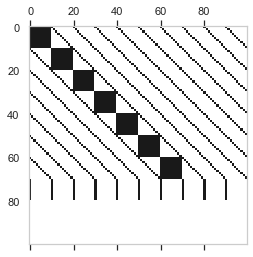

In [84]:
T = 10
Nt = 10
Nx = 10
a = 1

def u_exact_z_s(z, s): 
    x = (z/2 + 1)*np.pi
    t = (s + 1)*T/2
    return f(x - c*t)
# 
def gl(s):
    return u_exact_z_s(-1, s)

def gr(s):
    return u_exact_z_s(1, s)

def phi0(z):
    return u_exact_z_s(z, -1)

z, s, phi_approx = IVP_as_BVP(Nx, Nt, T, a, phi0, gl, gr)

Zgrid, Sgrid = np.meshgrid(z, s)


# grid, phi_approx = IVP_as_BVP(Nx, Nt, T, a, phi0, gl, gr)

# Zgrid, Sgrid = np.meshgrid(grid, grid)

fig, ax = plt.subplots(1, 1, figsize=(14,5))

# for i in range(0, len(grid), 50):
#     ax.plot(grid, phi_approx[:, i], label=f"t={T/2*(grid[i]+1)}")

for i in range(0, len(s), 5):
    ax.plot(z, phi_approx[:, i], label=f"t={T/2*(s[i]+1)}")

ax.legend()

# fig, ax = plt.subplots(1, 1, figsize=(7,7), subplot_kw={"projection": "3d"})
ax.plot_surface(Zgrid, Sgrid, phi_approx)
# ax.plot_surface(Zgrid, Sgrid, u_exact_z_s(Zgrid, Sgrid))

# fig, ax = plt.subplots(1, 1, figsize=(7,7), subplot_kw={"projection": "3d"})
# ax.plot_surface(Zgrid, Sgrid, abs(phi_approx - u_exact_z_s(Zgrid, Sgrid)))
# # ax.set_zscale('log')